<a href="https://colab.research.google.com/github/lina-martinez/Modelo-clasificacion-multiclases-para-prediccion-de-apuestas-deportivas/blob/master/Alternativo_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importaciones

In [ ]:
# Tratamiento de datos
import re
import io
import json
import lxml
import requests
import math
import numpy as np
import pandas as pd

# Gráficos
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from collections import defaultdict # Para generar un diccionario nuevo de valores
from bs4 import BeautifulSoup

# Preprocesado y modelado
import lightgbm as lgb
import multiprocessing

import xgboost as xgb

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats
from scipy.special import entr # Entropía de Shannon
from scipy.stats import multivariate_normal # Modelo de distribución gaussiana multivariable
from scipy.stats import median_abs_deviation # MAD
from scipy.stats import iqr # Interquartile range

from sklearn import svm, metrics
from sklearn.svm import SVC

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures # Características Polinomiales
from sklearn.preprocessing import OneHotEncoder # Librería donde está el método One-Hot Encoder
from sklearn.preprocessing import LabelEncoder # Codificación de etiquetas
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA # Análisis de Componentes Principales
from sklearn.decomposition import KernelPCA # Kernel PCA
from sklearn.decomposition import SparsePCA # PCA esparcido
from sklearn.decomposition import MiniBatchSparsePCA # Mini Batch PCA esparcido
from sklearn.decomposition import IncrementalPCA # PCA incremental
from sklearn.decomposition import FastICA # Análisis de Componentes Independientes

from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparametros
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

from sklearn.linear_model import RANSACRegressor, LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, f1_score, auc
from sklearn.metrics import roc_auc_score, precision_score, roc_curve, confusion_matrix, classification_report, make_scorer, accuracy_score

from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier

from sklearn.ensemble import AdaBoostClassifier ,RandomForestClassifier ,GradientBoostingClassifier

from sklearn.datasets import make_multilabel_classification , load_iris, make_classification

from sklearn.naive_bayes import GaussianNB, BernoulliNB ,MultinomialNB

from sklearn.covariance import EllipticEnvelope # Estimación de Covarianza
from sklearn.utils.extmath import safe_sparse_dot # Producto punto entre matrices esparcidos para SparsePCA.
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import GaussianRandomProjection
from sklearn.multioutput import ClassifierChain
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE

#Funciones

In [ ]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [ ]:
def filtrar_campo(df_filtrar_campo,col,val):
 '''Filtra un DF por campo y valor dado'''
 return df_filtrar_campo[df_filtrar_campo[col]==val]  

In [ ]:
def filtrar_n_ultimos_juegos(df,n,fecha,columnas_a_filtrar,valores_a_filtrar):
  '''ordena por fecha un df y lo filtra hasta una fecha dada segun lista de campos y valores dados, si hay un filtro por valores excluyentes no se to ejecuta'''
  df_retorna=df.copy()
  df_retorna=df_retorna[df_retorna['Historia.Fecha']<fecha]  
  for columna,valor in zip(columnas_a_filtrar,valores_a_filtrar):
    df_retorna=filtrar_campo(df_retorna,columna,valor)
  df_retorna.sort_values(by='Historia.Fecha', ascending = False,inplace=True)
  return df_retorna[:n]

In [ ]:
def traer_informacion_historica(df_historico,cantidad_juegos,fecha_proximo_juego,campos_a_filtrar,valores_a_filtrar,prefijo):
  #df_ultimos_juegos=filtrar_n_ultimos_juegos(dataset_historia,3,'2023-02-19',['Historia.id_Equipo_Analizado'],['94'])
  df_ultimos_juegos=filtrar_n_ultimos_juegos(df_historico,cantidad_juegos,fecha_proximo_juego,campos_a_filtrar,valores_a_filtrar)
  df_dinamizado=dinamizar_columnas(df_ultimos_juegos,prefijo)
  return df_dinamizado

In [ ]:
def dinamizar_columnas(df,prefijo):
  ''' recibe un DF y lo convierte en un df de una sola fila'''
  lista_campos=[]
  lista_valores=[]
  for col in df.iloc[: , :-1]:
    lista=list(df[col])
    for fil in range(len(lista)):
      lista_campos.append(f"{prefijo}.{col} N-{fil+1}")
      lista_valores.append(lista[fil])
  df_generado=pd.DataFrame([lista_valores],columns=lista_campos)
  return  df_generado  

#Construccion Data

In [ ]:
#Definición de parámetros

partidos_historicos=10

equipos=['Verona','Roma','Lazio','Bologna','Juventus','Udinese','Sampdoria','Sassuolo',
         'Napoli','Inter','Atalanta','Empoli','Fiorentina','AC Milan','Torino','Lecce',
         'Spezia','Salernitana','Monza','Cremonese','Genoa','Cagliari','Venezia','Crotone',
         'Benevento','Parma Calcio 1913']

id_equipos=['94', '95','96', '97', '98', '99', '102', '104', '105', '106', 
            '107', '108', '110', '111','113', '243', '260', '264', '271', 
            '272','101','116','265','115','222','230'	]

In [ ]:
#Construir el dataset
dataset_inicial=pd.DataFrame([])
for _ in equipos: 
  base_url_game='https://understat.com/team/' #Consultar la API
  team = _ #str(input('please enter the team name:'))
  temporadas=['2022','2021','2020','2019','2018','2017','2016','2015']
  for season in temporadas:
    url_game = base_url_game + team +"/"+season
    res_game = requests.get(url_game)
    soup_game = BeautifulSoup(res_game.content,'lxml')
    scripts_game = soup_game.find_all('script')
    strings_game = scripts_game[1].string
    ind_start_game = strings_game.index("('")+2
    ind_end_game = strings_game.index("')")
    json_data_game =strings_game[ind_start_game:ind_end_game]
    json_data_game =json_data_game.encode('utf8').decode('unicode_escape')
    data_game=json.loads(json_data_game)
    data_game= pd.json_normalize(data_game)
    data_game=data_game.assign(Equipo_Analizado=team)
    dataset_inicial=pd.concat([dataset_inicial,data_game])

In [ ]:
#Formato a las columnas
dataset_inicial.columns=['Id_Juego', 'Jugado', 'Local', 'Fecha_Juego', 'Resultado_Local', 'Id_Local', 'Nombre_Local',
       'Nombre_Corto_local', 'Id_Visitante', 'Nombre_Visitante','Nombre_Corto_Visitante', 'Goles_Local',
       'Goles_Visitante', 'Goles_Esperados_local', 'Goles_Esperados_Visitante', 'Probabilidad_Victoria_Local', 'Probabilidad_Empate', 'Probabilidad_Derrota_Local','Equipo_Analizado']
dataset_inicial=dataset_inicial[dataset_inicial['Nombre_Local']==dataset_inicial['Equipo_Analizado']]
dataset_inicial=dataset_inicial.drop(['Local','Nombre_Local','Nombre_Corto_local','Nombre_Visitante','Nombre_Corto_Visitante','Equipo_Analizado'], axis=1)
dataset_inicial['Fecha_Juego'] = pd.to_datetime(dataset_inicial['Fecha_Juego'])
dataset_inicial.head(10)

,Id_Juego,Jugado,Fecha_Juego,Resultado_Local,Id_Local,Id_Visitante,Goles_Local,Goles_Visitante,Goles_Esperados_local,Goles_Esperados_Visitante,Probabilidad_Victoria_Local,Probabilidad_Empate,Probabilidad_Derrota_Local
0,18590,True,2022-08-15 16:30:00,l,94,105,2,5,1.13087,2.79803,0.127051,0.152316,0.720633
2,18609,True,2022-08-28 16:30:00,l,94,107,0,1,0.369511,0.843159,0.153387,0.397532,0.449081
4,18627,True,2022-09-04 16:00:00,w,94,102,2,1,2.3433,0.798714,0.719050,0.170730,0.110220
7,18654,True,2022-10-03 18:45:00,l,94,99,1,2,0.284674,2.17728,0.037251,0.146894,0.815854
9,18674,True,2022-10-16 18:45:00,l,94,111,1,2,1.93604,1.7368,0.431950,0.215935,0.352114
11,18694,True,2022-10-31 17:30:00,l,94,95,1,3,0.288065,3.03255,0.017844,0.075293,0.906862
13,18714,True,2022-11-10 17:30:00,l,94,98,0,1,1.14515,0.877959,0.418104,0.302597,0.279300
14,18725,True,2022-11-13 14:00:00,l,94,260,1,2,2.16554,0.752225,0.698430,0.185163,0.116407
16,18744,True,2023-01-09 17:30:00,w,94,272,2,0,1.92775,0.810314,0.636773,0.212783,0.150444
18,18764,True,2023-01-21 14:00:00,w,94,243,2,0,0.625033,0.835357,0.252802,0.370125,0.377073


In [ ]:
#Genero la hisotria
dataset_historia=pd.DataFrame([])
temporadas=['2022','2021','2020','2019','2018','2017','2016','2015']
base_url_history='https://understat.com/league/'
match = 'Serie_A/' # str(input('please enter the match id:'))
for temporada in temporadas:
  url_history = base_url_history + match + temporada
  res_history = requests.get(url_history)
  soup_history = BeautifulSoup(res_history.content,'lxml')
  scripts_history = soup_history.find_all('script')
  strings_history = scripts_history[2].string
  ind_start_history = strings_history.index("('")+2
  ind_end_history = strings_history.index("')")
  json_data_history=strings_history[ind_start_history:ind_end_history]
  json_data_history=json_data_history.encode('utf8').decode('unicode_escape')
  data_history=json.loads(json_data_history)
  for _ in id_equipos:
    if _ in data_history:
      data_statistics_history= pd.json_normalize(data_history[_]['history'])
      data_statistics_history=data_statistics_history.assign(id_Equipo_Analizado=_)
      dataset_historia=pd.concat([dataset_historia,data_statistics_history])
# dataset_historia

In [ ]:
#Obtener información sobre los partidos anteriores 
dataset_historia=dataset_historia.drop(['xG','xGA','npxG','npxGA','deep','deep_allowed','xpts','result','wins',	'draws'	,'loses','npxGD','ppda.att','ppda.def',	'ppda_allowed.att','ppda_allowed.def'], axis=1)
dataset_historia.columns=['Historia.local','Historia.Goles_Local','Historia.Goles_Visitante','Historia.Fecha','Historia.Puntos','Historia.id_Equipo_Analizado']
dataset_historia['Historia.Fecha'] = pd.to_datetime(dataset_historia['Historia.Fecha'])
dataset_historia.head(10)

,Historia.local,Historia.Goles_Local,Historia.Goles_Visitante,Historia.Fecha,Historia.Puntos,Historia.id_Equipo_Analizado
0,h,2,5,2022-08-15 16:30:00,0,94
1,a,1,1,2022-08-21 18:45:00,1,94
2,h,0,1,2022-08-28 16:30:00,0,94
3,a,1,1,2022-08-31 16:30:00,1,94
4,h,2,1,2022-09-04 16:00:00,3,94
5,a,0,2,2022-09-11 16:00:00,0,94
6,a,0,2,2022-09-18 13:00:00,0,94
7,h,1,2,2022-10-03 18:45:00,0,94
8,a,1,2,2022-10-09 13:00:00,0,94
9,h,1,2,2022-10-16 18:45:00,0,94


In [ ]:
df_juegos_informacion_historica=pd.DataFrame([])

i=0
for _ in range(dataset_inicial.shape[0]):
  df_ext_local=traer_informacion_historica(dataset_historia,partidos_historicos,dataset_inicial.iloc[_]['Fecha_Juego'],['Historia.id_Equipo_Analizado'],[dataset_inicial.iloc[_]['Id_Local']],'local')
  df_ext_visit=traer_informacion_historica(dataset_historia,partidos_historicos,dataset_inicial.iloc[_]['Fecha_Juego'],['Historia.id_Equipo_Analizado'],[dataset_inicial.iloc[_]['Id_Visitante']],'Visitante') 

  df_intermedio = pd.concat([df_ext_local,df_ext_visit], axis=1)
  x = pd.DataFrame(dataset_inicial.iloc[_])
  x = x.transpose(copy=True)
  x.reset_index()
  df_intermedio = pd.concat([df_intermedio,x.reset_index()], axis=1)

  df_juegos_informacion_historica = pd.concat([df_juegos_informacion_historica, df_intermedio])
df_juegos_informacion_historica.head(10)

<ipython-input-4-e27c9f56cffc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retorna.sort_values(by='Historia.Fecha', ascending = False,inplace=True)
<ipython-input-4-e27c9f56cffc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retorna.sort_values(by='Historia.Fecha', ascending = False,inplace=True)


,local.Historia.local N-1,local.Historia.local N-2,local.Historia.local N-3,local.Historia.local N-4,local.Historia.local N-5,local.Historia.local N-6,local.Historia.local N-7,local.Historia.local N-8,local.Historia.local N-9,local.Historia.local N-10,local.Historia.Goles_Local N-1,local.Historia.Goles_Local N-2,local.Historia.Goles_Local N-3,local.Historia.Goles_Local N-4,local.Historia.Goles_Local N-5,local.Historia.Goles_Local N-6,local.Historia.Goles_Local N-7,local.Historia.Goles_Local N-8,local.Historia.Goles_Local N-9,local.Historia.Goles_Local N-10,local.Historia.Goles_Visitante N-1,local.Historia.Goles_Visitante N-2,local.Historia.Goles_Visitante N-3,local.Historia.Goles_Visitante N-4,local.Historia.Goles_Visitante N-5,local.Historia.Goles_Visitante N-6,local.Historia.Goles_Visitante N-7,local.Historia.Goles_Visitante N-8,local.Historia.Goles_Visitante N-9,local.Historia.Goles_Visitante N-10,local.Historia.Fecha N-1,local.Historia.Fecha N-2,local.Historia.Fecha N-3,local.Historia.Fecha N-4,local.Historia.Fecha N-5,local.Historia.Fecha N-6,local.Historia.Fecha N-7,local.Historia.Fecha N-8,local.Historia.Fecha N-9,local.Historia.Fecha N-10,local.Historia.Puntos N-1,local.Historia.Puntos N-2,local.Historia.Puntos N-3,local.Historia.Puntos N-4,local.Historia.Puntos N-5,local.Historia.Puntos N-6,local.Historia.Puntos N-7,local.Historia.Puntos N-8,local.Historia.Puntos N-9,local.Historia.Puntos N-10,Visitante.Historia.local N-1,Visitante.Historia.local N-2,Visitante.Historia.local N-3,Visitante.Historia.local N-4,Visitante.Historia.local N-5,Visitante.Historia.local N-6,Visitante.Historia.local N-7,Visitante.Historia.local N-8,Visitante.Historia.local N-9,Visitante.Historia.local N-10,Visitante.Historia.Goles_Local N-1,Visitante.Historia.Goles_Local N-2,Visitante.Historia.Goles_Local N-3,Visitante.Historia.Goles_Local N-4,Visitante.Historia.Goles_Local N-5,Visitante.Historia.Goles_Local N-6,Visitante.Historia.Goles_Local N-7,Visitante.Historia.Goles_Local N-8,Visitante.Historia.Goles_Local N-9,Visitante.Historia.Goles_Local N-10,Visitante.Historia.Goles_Visitante N-1,Visitante.Historia.Goles_Visitante N-2,Visitante.Historia.Goles_Visitante N-3,Visitante.Historia.Goles_Visitante N-4,Visitante.Historia.Goles_Visitante N-5,Visitante.Historia.Goles_Visitante N-6,Visitante.Historia.Goles_Visitante N-7,Visitante.Historia.Goles_Visitante N-8,Visitante.Historia.Goles_Visitante N-9,Visitante.Historia.Goles_Visitante N-10,Visitante.Historia.Fecha N-1,Visitante.Historia.Fecha N-2,Visitante.Historia.Fecha N-3,Visitante.Historia.Fecha N-4,Visitante.Historia.Fecha N-5,Visitante.Historia.Fecha N-6,Visitante.Historia.Fecha N-7,Visitante.Historia.Fecha N-8,Visitante.Historia.Fecha N-9,Visitante.Historia.Fecha N-10,Visitante.Historia.Puntos N-1,Visitante.Historia.Puntos N-2,Visitante.Historia.Puntos N-3,Visitante.Historia.Puntos N-4,Visitante.Historia.Puntos N-5,Visitante.Historia.Puntos N-6,Visitante.Historia.Puntos N-7,Visitante.Historia.Puntos N-8,Visitante.Historia.Puntos N-9,Visitante.Historia.Puntos N-10,index,Id_Juego,Jugado,Fecha_Juego,Resultado_Local,Id_Local,Id_Visitante,Goles_Local,Goles_Visitante,Goles_Esperados_local,Goles_Esperados_Visitante,Probabilidad_Victoria_Local,Probabilidad_Empate,Probabilidad_Derrota_Local
0,a,h,h,a,h,a,a,h,a,h,3.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,2022-05-21 18:45:00,2022-05-14 16:00:00,2022-05-08 18:45:00,2022-04-30 13:00:00,2022-04-23 18:45:00,2022-04-18 19:00:00,2022-04-09 16:00:00,2022-04-04 16:30:00,2022-03-20 14:00:00,2022-03-13 14:00:00,1.0,0.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,0.0,a,h,a,h,a,h,h,a,h,a,3.0,3.0,1.0,6.0,2.0,1.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,2022-05-22 10:30:00,2022-05-15 13:00:00,2022-05-07 13:00:00,2022-04-30 13:00:00,2022-04-24 13:00:00,2022-04-18 17:00:00,2022-04-10 13:00:00,2022-04-03 13:00:00,2022-03-19 14:00:00,2022-03-13 14:00:00,3.0,3.0,3.0,3.0,0.0,1.0,0.0,3.0,3.0,3.0,0,18590,True,2022-08-15 16:30:00,l,94,105,2,

In [ ]:
df_juegos_informacion_historica=df_juegos_informacion_historica.drop(['index','Id_Juego','Goles_Esperados_local',
                                                                      'Goles_Esperados_Visitante','Probabilidad_Victoria_Local','Probabilidad_Empate'
                                                                      ,'Probabilidad_Derrota_Local'], axis=1)  

#limpieza de datos

Separo partidos jugados y partidos sin jugar

In [ ]:
df=df_juegos_informacion_historica[df_juegos_informacion_historica['Jugado']==True]
df_partidos_sin_jugar=df_juegos_informacion_historica[df_juegos_informacion_historica['Jugado']==False]

Se eliminan los partidos registros que no tienen hisotria para ninguno de los equipos y llevan menos de 3 partidos jugados

In [ ]:
df=df[-((df['local.Historia.local N-1'].isnull()) & (df['Visitante.Historia.local N-1'].isnull()))]
df=df[-((df['local.Historia.local N-2'].isnull()) & (df['Visitante.Historia.local N-2'].isnull()))]
df=df[-((df['local.Historia.local N-3'].isnull()) & (df['Visitante.Historia.local N-3'].isnull()))]

Se eliminan los partidos donde se tenga informacion de menos de 3 partidos

In [ ]:

df=df[-((df['local.Historia.local N-1'].isnull()) & (df['Visitante.Historia.local N-2'].isnull()))]
df=df[-((df['local.Historia.local N-2'].isnull()) & (df['Visitante.Historia.local N-1'].isnull()))]
df=df[-((df['local.Historia.local N-1'].isnull()) & (df['Visitante.Historia.local N-3'].isnull()))]
df=df[-((df['local.Historia.local N-3'].isnull()) & (df['Visitante.Historia.local N-1'].isnull()))]
df=df[-((df['local.Historia.local N-1'].isnull()) & (df['Visitante.Historia.local N-4'].isnull()))]
df=df[-((df['local.Historia.local N-4'].isnull()) & (df['Visitante.Historia.local N-1'].isnull()))]

Se reemplazan los valores faltantes por -1 para que se tenga en cuenta con los valores de los partidos jugados

In [ ]:
#Rellenar espacios vacios con (-1)
for _ in df.columns:
    if df[_].dtype != 'datetime64[ns]':
      df[_].fillna(-1, inplace=True)

In [ ]:
df = df.reset_index(drop=True)

#Preparación de los datos

Las columnas de fechas se les reemplará por los días entre la fecha que se jugó y la fecha del juego que se analiza en esa fila

In [ ]:
df['local.Historia.Fecha N-1'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-1'])).dt.days
df['local.Historia.Fecha N-2'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-2'])).dt.days
df['local.Historia.Fecha N-3'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-3'])).dt.days
df['local.Historia.Fecha N-4'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-4'])).dt.days
df['local.Historia.Fecha N-5'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-5'])).dt.days
df['local.Historia.Fecha N-6'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-6'])).dt.days
df['local.Historia.Fecha N-7'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-7'])).dt.days
df['local.Historia.Fecha N-8'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-8'])).dt.days
df['local.Historia.Fecha N-9'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-9'])).dt.days
df['local.Historia.Fecha N-10'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['local.Historia.Fecha N-10'])).dt.days
df['Visitante.Historia.Fecha N-1'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-1'])).dt.days
df['Visitante.Historia.Fecha N-2'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-2'])).dt.days
df['Visitante.Historia.Fecha N-3'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-3'])).dt.days
df['Visitante.Historia.Fecha N-4'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-4'])).dt.days
df['Visitante.Historia.Fecha N-5'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-5'])).dt.days
df['Visitante.Historia.Fecha N-6'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-6'])).dt.days
df['Visitante.Historia.Fecha N-7'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-7'])).dt.days
df['Visitante.Historia.Fecha N-8'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-8'])).dt.days
df['Visitante.Historia.Fecha N-9'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-9'])).dt.days
df['Visitante.Historia.Fecha N-10'] = (pd.to_datetime(df['Fecha_Juego']) - pd.to_datetime(df['Visitante.Historia.Fecha N-10'])).dt.days

Ordeno el df por fecha, de mas viejo a mas nuevo


In [ ]:
df = df.sort_values('Fecha_Juego')

Se pone en la columna fecha los dias que faltan para que acabe el año del partido en analisis

In [ ]:
df['Fecha_Juego'] = (12 - df['Fecha_Juego'].dt.month  ) # Calculamos los meses restantes

**Codificación de etiquetas**
Para las columnas de local.historia, visitante.historia y resultado local

local-historia: si la columna contiene la 'a' de visitante se le asigna un 1 y 'h' de local se le asigna el cero, si tiene el -1 es porque no se tiene información.

Visitante.Historia: si la columna contiene la 'a' de visitante se le asigna un 1 y 'h' de local se le asigna el cero, si tiene el -1 es porque no se tiene información.

La columna jugado nos dice True si el partido ya se jugo y False si el partido aún no se ha jugado, pero como se puede observar esta columna tiene un único valor por lo que no nos aporta en el modelo y se elimina

La variable Resultado_Local tiene tres posibles resultados, 'W' ganador, 'l' perdedor, 'd' empate.
['l' 'w' 'd']

In [ ]:
df['local.Historia.local N-1'] = df['local.Historia.local N-1'].replace(['a','h'],[1,0])
df['local.Historia.local N-2'] = df['local.Historia.local N-2'].replace(['a','h'],[1,0])
df['local.Historia.local N-3'] = df['local.Historia.local N-3'].replace(['a','h'],[1,0])
df['local.Historia.local N-4'] = df['local.Historia.local N-4'].replace(['a','h'],[1,0])
df['local.Historia.local N-5'] = df['local.Historia.local N-5'].replace(['a','h'],[1,0])
df['local.Historia.local N-6'] = df['local.Historia.local N-6'].replace(['a','h'],[1,0])
df['local.Historia.local N-7'] = df['local.Historia.local N-7'].replace(['a','h'],[1,0])
df['local.Historia.local N-8'] = df['local.Historia.local N-8'].replace(['a','h'],[1,0])
df['local.Historia.local N-9'] = df['local.Historia.local N-9'].replace(['a','h'],[1,0])
df['local.Historia.local N-10'] = df['local.Historia.local N-10'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-1'] = df['Visitante.Historia.local N-1'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-2'] = df['Visitante.Historia.local N-2'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-3'] = df['Visitante.Historia.local N-3'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-4'] = df['Visitante.Historia.local N-4'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-5'] = df['Visitante.Historia.local N-5'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-6'] = df['Visitante.Historia.local N-6'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-7'] = df['Visitante.Historia.local N-7'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-8'] = df['Visitante.Historia.local N-8'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-9'] = df['Visitante.Historia.local N-9'].replace(['a','h'],[1,0])
df['Visitante.Historia.local N-10'] = df['Visitante.Historia.local N-10'].replace(['a','h'],[1,0])
df['Resultado_Local'] = df['Resultado_Local'].replace(['w','l','d'],[2,1,0])

In [ ]:
df = df.drop(['Jugado'], axis=1)

Se realiza un One Hot Encoder para las columnas de Id Local y Id Visitante

In [ ]:
one_hot_encoding = pd.get_dummies(df['Id_Local'],prefix='Local')
df = pd.concat([df, one_hot_encoding], axis=1)

In [ ]:
one_hot_encoding = pd.get_dummies(df['Id_Visitante'],prefix='Visita')
df = pd.concat([df, one_hot_encoding], axis=1)

Convierto todo a float

In [ ]:
df=df.astype('float64')

Reemplazo todos los Nulos por -1

In [ ]:
df.fillna(-1, inplace=True)

# Dividir el conjunto de datos

Ordeno las variables dependientes, Doonde se separa la etiqueta de goles, 0 o 1 gol valor de etiqueta 0, 2 o mas goles valor de etiqueta 1

In [ ]:
dfy_resultado_local=df['Resultado_Local']
dfy_goles_local=np.where(df['Goles_Local'] <= 1,0 , 1)
dfy_goles_visita=np.where(df['Goles_Visitante'] <= 1,0 , 1)

Y = dfy_goles_local
X = df.drop(['Goles_Local','Goles_Visitante','Resultado_Local'], axis=1) 

Separo las variables de entrenamiento y prueba, buscando que los ultimos registros (los mas nuevos) sean los de prueba

In [ ]:
porcentaje_entrenamiento = 0.8
porcentaje_prueba = 1 - porcentaje_entrenamiento

# Calcular índice de separación de los datos
indice_separacion = int(len(df) * porcentaje_entrenamiento)

# Separar los datos en conjuntos de entrenamiento y prueba
datos_entrenamiento_completos = df[:indice_separacion]
datos_prueba_completos = df[indice_separacion:]

Datos train

In [ ]:
y_train_Goles_Local=np.where(datos_entrenamiento_completos['Goles_Local'] <= 1,0 , 1)
y_train_Goles_Visitante= np.where(datos_entrenamiento_completos['Goles_Visitante'] <= 1,0 , 1) 
y_train_Resultado_Local=datos_entrenamiento_completos['Resultado_Local']

x_train=datos_entrenamiento_completos.drop(['Goles_Local','Goles_Visitante','Resultado_Local'], axis=1).copy()

Datos Test

In [ ]:
y_test_Goles_Local= np.where(datos_prueba_completos['Goles_Local'] <= 1,0 , 1) 
y_test_Goles_Visitante= np.where(datos_prueba_completos['Goles_Visitante'] <= 1,0 , 1)  
y_test_Resultado_Local=datos_prueba_completos['Resultado_Local']

x_test=datos_prueba_completos.drop(['Goles_Local','Goles_Visitante','Resultado_Local'], axis=1).copy()

#GFradient Boosting

In [ ]:
X_train_GFradient = x_train.copy()
y_train_GFradient = y_train_Goles_Local.copy()
X_test_GFradient = x_test.copy()
y_test_GFradient = y_test_Goles_Local.copy()

### Entrenamiento del modelo

In [ ]:
# Definición de hiperparámetros
params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 3
}

# Entrenamiento del modelo
model_Gradient = GradientBoostingClassifier(**params)
model_Gradient.fit(X_train_GFradient, y_train_GFradient)

# Evaluación del modelo
y_pred_GF = model_Gradient.predict(X_test_GFradient)
accuracy = accuracy_score(y_test_GFradient, y_pred_GF)
print(f"Precisión: {accuracy}")

Precisión: 0.6448979591836734


### Matriz de confusión

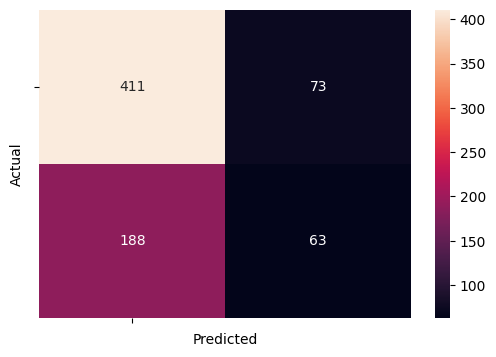

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       484
           1       0.46      0.25      0.33       251

    accuracy                           0.64       735
   macro avg       0.57      0.55      0.54       735
weighted avg       0.61      0.64      0.61       735

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       484
           1       0.46      0.25      0.33       251

    accuracy                           0.64       735
   macro avg       0.57      0.55      0.54       735
weighted avg       0.61      0.64      0.61       735



In [ ]:
conf_mat = confusion_matrix(y_test_GFradient, y_pred_GF)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_GFradient, y_pred_GF))
print(classification_report(y_test_GFradient, y_pred_GF))

### Curva ROC

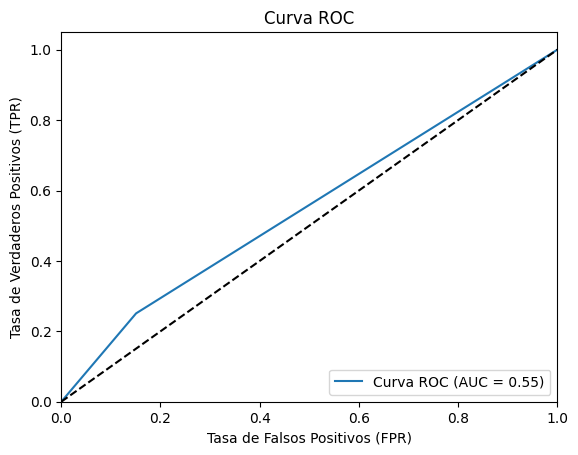

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_GFradient, y_pred_GF)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Validacíón cruzada

In [ ]:
# Valores de ccp_alpha evaluados
param_grid = param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = GradientBoostingClassifier(),
        param_grid = param_grid,
        scoring    = 'f1',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_GFradient, y_train_GFradient)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='f1')

In [ ]:
# Evaluación del modelo
y_pred_GF = grid.predict(X_test_GFradient)
accuracy = accuracy_score(y_test_GFradient, y_pred_GF)
print(f"Precisión: {accuracy}")

Precisión: 0.6231292517006802


##Mejores Hiperparametros

In [ ]:
param_grid = {
    'learning_rate': [0.5,0.1, 0.01],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.5, 0.8, 1.0]
}
scoring = 'accuracy'
gb = GradientBoostingClassifier()
grid = GridSearchCV(gb, param_grid=param_grid, scoring=scoring, cv=5)
grid.fit(X_train_GFradient, y_train_Goles_Local)
print(f"Mejores parámetros: {grid.best_params_}")
print(f"Rendimiento: {grid.best_score_}")



Mejores parámetros: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.5}
Rendimiento: 0.5935374149659864


In [ ]:

y_pred_grid = grid.predict(X_test_GFradient)
accuracy = accuracy_score(y_test_GFradient, y_pred_grid)
print(f"Precisión: {accuracy}")

Precisión: 0.6585034013605442


##Nueva Matriz de confusión

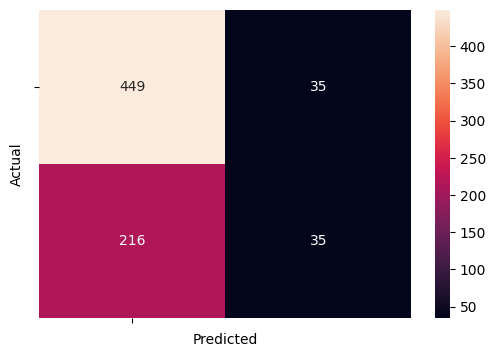

              precision    recall  f1-score   support

           0       0.68      0.93      0.78       484
           1       0.50      0.14      0.22       251

    accuracy                           0.66       735
   macro avg       0.59      0.53      0.50       735
weighted avg       0.62      0.66      0.59       735

              precision    recall  f1-score   support

           0       0.68      0.93      0.78       484
           1       0.50      0.14      0.22       251

    accuracy                           0.66       735
   macro avg       0.59      0.53      0.50       735
weighted avg       0.62      0.66      0.59       735



In [ ]:
conf_mat = confusion_matrix(y_test_GFradient, y_pred_grid)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_GFradient, y_pred_grid))
print(classification_report(y_test_GFradient, y_pred_grid))

#Regresion logistica

In [ ]:
X_train_RL = x_train.copy()
y_train_RL = y_train_Goles_Local.copy()
X_test_RL = x_test.copy()
y_test_RL = y_test_Goles_Local.copy()

### Entreamiento del modelo

In [ ]:
logreg = LogisticRegression(max_iter=1000,solver="sag",)
logreg.fit(X_train_RL, y_train_RL)
y_pred_RL = logreg.predict(X_test_RL)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print("Modelo Regresión Logistica:",metrics.accuracy_score(y_test_RL, y_pred_RL))

Modelo Regresión Logistica: 0.6598639455782312


### Matriz de confusión

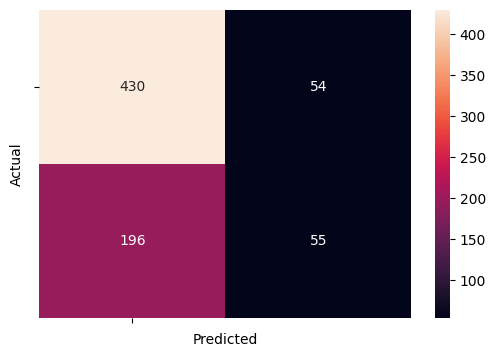

              precision    recall  f1-score   support

           0       0.69      0.89      0.77       484
           1       0.50      0.22      0.31       251

    accuracy                           0.66       735
   macro avg       0.60      0.55      0.54       735
weighted avg       0.62      0.66      0.61       735

              precision    recall  f1-score   support

           0       0.69      0.89      0.77       484
           1       0.50      0.22      0.31       251

    accuracy                           0.66       735
   macro avg       0.60      0.55      0.54       735
weighted avg       0.62      0.66      0.61       735



In [ ]:
conf_mat = confusion_matrix(y_test_RL, y_pred_RL)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_RL, y_pred_RL))
print(classification_report(y_test_RL, y_pred_RL))

### Curva ROC

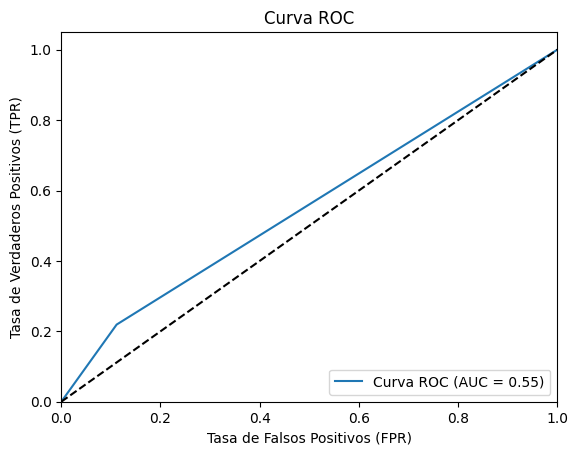

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_RL, y_pred_RL)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Validación cruzada

In [ ]:
# Valores de ccp_alpha evaluados
param_grid = param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = GradientBoostingClassifier(),
        param_grid = param_grid,
        scoring    = 'f1',
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train_RL, y_train_RL)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='f1')

In [ ]:
# Evaluación del modelo
y_pred_RL = grid.predict(X_test_RL)
accuracy = accuracy_score(y_test_RL, y_pred_RL)
print(f"Precisión: {accuracy}")

##Mejores Hiperparametros

In [ ]:
parameters = {'penalty': ['none', 'l2'],'max_iter':[1000,10000],'solver':["sag","newton-cg", "lbfgs", "liblinear"],'multi_class':["ovr","multinomial"]}
grid = GridSearchCV(logreg, parameters, cv=5)
grid.fit(X_train_RL, y_train_RL)
print("Mejores parámetros: ", grid.best_params_)
print("Puntaje de validación cruzada promedio: ", grid.best_score_)
print("Puntaje en los datos de prueba: ", grid.score(X_test_RL, y_test_RL))

y_pred_RL_Grid = grid.predict(X_test_RL)

##Nueva Matriz de confusión

In [ ]:
conf_mat = confusion_matrix(y_test_GFradient, y_pred_RL_Grid)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_GFradient, y_pred_RL_Grid))
print(classification_report(y_test_GFradient, y_pred_RL_Grid))

Dado que no se esta obteniendo los valores deseados, se realizá una reducción de dimensionalidad

# T -SNE 

In [ ]:
Y_goles_local = pd.DataFrame(dfy_goles_local)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3675 entries, 850 to 298
Columns: 162 entries, local.Historia.local N-1 to Visita_99
dtypes: float64(162)
memory usage: 4.6 MB


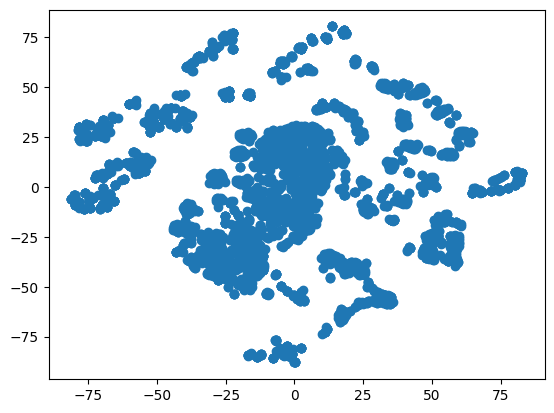

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [ ]:
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(
                                        X_tsne,
                                        Y_goles_local.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Random Forest

In [ ]:
X_train_Random_Forest = x_train.copy()
y_train_Random_Forest = y_train_Goles_Local.copy()
X_test_Random_Forest = x_test.copy()
y_test_Random_Forest = y_test_Goles_Local.copy()

###Dataset Completo

#### Entrenamiento del modelo

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train_Random_Forest, y_train_Random_Forest)

# Hacer predicciones sobre nuevas instancias
y_pred_RF = rfc.predict(X_test_Random_Forest)
print("Precisión del modelo: ", accuracy_score(y_test_Random_Forest, y_pred_RF))

Precisión del modelo:  0.6598639455782312


#### Matriz de confusión

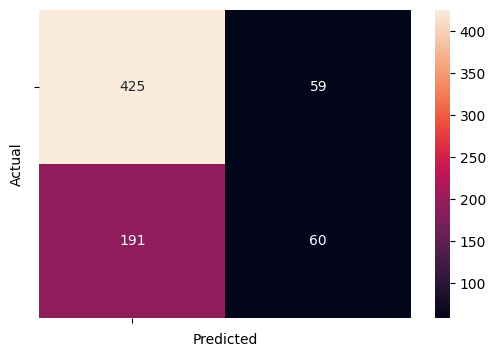

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       484
           1       0.50      0.24      0.32       251

    accuracy                           0.66       735
   macro avg       0.60      0.56      0.55       735
weighted avg       0.63      0.66      0.62       735

              precision    recall  f1-score   support

           0       0.69      0.88      0.77       484
           1       0.50      0.24      0.32       251

    accuracy                           0.66       735
   macro avg       0.60      0.56      0.55       735
weighted avg       0.63      0.66      0.62       735



In [ ]:
conf_mat = confusion_matrix(y_test_Random_Forest, y_pred_RF)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_Random_Forest, y_pred_RF))
print(classification_report(y_test_Random_Forest, y_pred_RF))

#### Curva ROC

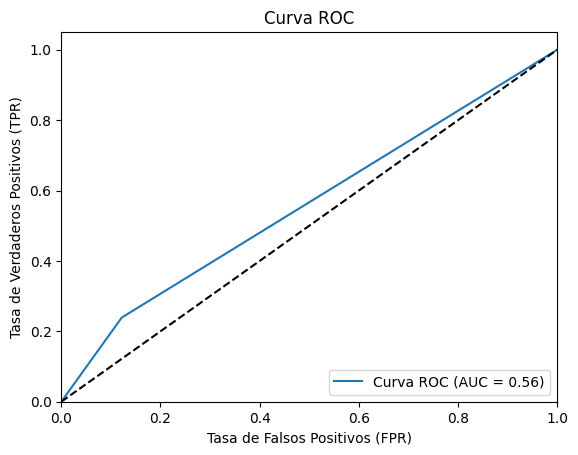

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_Random_Forest, y_pred_RF)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Validación cruzada

In [ ]:
# ==============================================================================
param_grid = {'n_estimators': [200],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'f1',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_Random_Forest , y = y_train_Random_Forest)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [ ]:
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

In [ ]:
modelo_final_RF = grid

In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final_RF.predict(X = X_test_Random_Forest)

In [ ]:
#Exactitud
print("Accuracy:",metrics.accuracy_score(y_test_Random_Forest, predicciones))

#### Nueva Matriz de confusión

In [ ]:
conf_mat = confusion_matrix(y_test_Random_Forest, predicciones)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_Random_Forest, predicciones))
print(classification_report(y_test_Random_Forest, predicciones))

###Dataset Reducido T-SNE

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train_tsne, y_train_tsne)

# Hacer predicciones sobre nuevas instancias
y_pred_RF = rfc.predict(X_test_tsne)
print("Precisión del modelo: ", accuracy_score(y_test_tsne, y_pred_RF))

<ipython-input-64-f7f09e51ee86>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train_tsne, y_train_tsne)


Precisión del modelo:  0.8884353741496599


#### Matriz de Confusión T-SNE

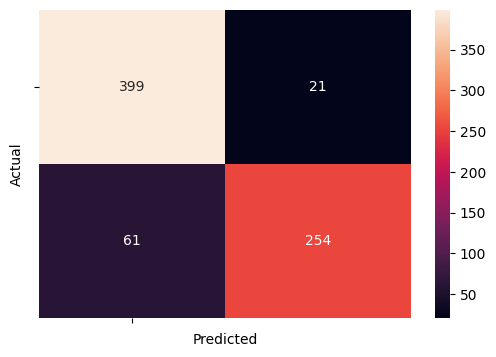

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       420
           1       0.92      0.81      0.86       315

    accuracy                           0.89       735
   macro avg       0.90      0.88      0.88       735
weighted avg       0.89      0.89      0.89       735

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       420
           1       0.92      0.81      0.86       315

    accuracy                           0.89       735
   macro avg       0.90      0.88      0.88       735
weighted avg       0.89      0.89      0.89       735



In [ ]:
conf_mat = confusion_matrix(y_test_tsne, y_pred_RF)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_tsne, y_pred_RF))
print(classification_report(y_test_tsne, y_pred_RF))

# Ada Boots

In [ ]:
X_train_AdaBoots = x_train.copy()
y_train_AdaBoots = y_train_Goles_Local.copy()
X_test_AdaBoots = x_test.copy()
y_test_AdaBoots = y_test_Goles_Local.copy()

###Dataset Completo

#### Entrenamiento del modelo

In [ ]:
#Crear un clasificador base
base_clf = DecisionTreeClassifier(max_depth=1)
# modelo
ada_clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=1)
# entrenar
ada_clf.fit(X_train_AdaBoots, y_train_AdaBoots)
y_pred_AB = ada_clf.predict(X_test_AdaBoots)
accuracy = accuracy_score(y_test_AdaBoots, y_pred_AB)
print(f"Precisión del modelo AdaBoost: {accuracy:.2f}")

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Precisión del modelo AdaBoost: 0.65


#### Matriz de confusión

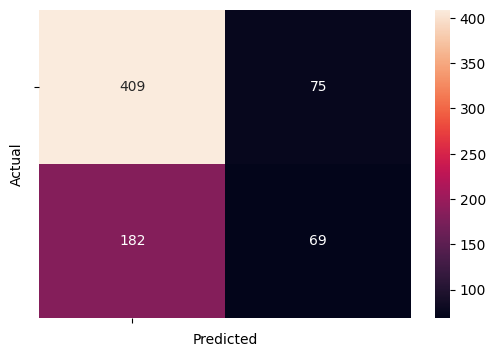

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       484
           1       0.48      0.27      0.35       251

    accuracy                           0.65       735
   macro avg       0.59      0.56      0.56       735
weighted avg       0.62      0.65      0.62       735

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       484
           1       0.48      0.27      0.35       251

    accuracy                           0.65       735
   macro avg       0.59      0.56      0.56       735
weighted avg       0.62      0.65      0.62       735



In [ ]:
conf_mat = confusion_matrix(y_test_AdaBoots, y_pred_AB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_AdaBoots, y_pred_AB))
print(classification_report(y_test_AdaBoots, y_pred_AB))

#### Curva ROC

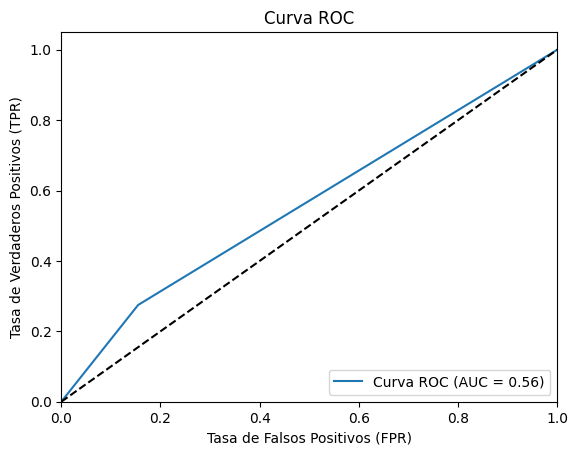

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_AdaBoots, y_pred_AB)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Validación cruzada

In [ ]:
# Definir la cuadrícula de valores para los hiperparámetros
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.5, 1.0]}

# Crear el modelo AdaBoost
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(ada_clf, param_grid, cv=5)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_AdaBoots, y_train_AdaBoots)

# Obtener los hiperparámetros óptimos y la precisión del modelo
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Precisión del modelo:", grid_search.best_score_)

In [ ]:
modelo_final_AB = grid

In [ ]:
# Error de test del modelo final
# ==============================================================================
predicciones_AB = modelo_final_AB.predict(X = X_test_AdaBoots)
predicciones_AB[:10]

In [ ]:
#Exactitud
print("Accuracy:",metrics.accuracy_score(y_test_AdaBoots, predicciones_AB))

#### Nueva Matriz de confusión

In [ ]:
conf_mat = confusion_matrix(y_test_AdaBoots, predicciones_AB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_AdaBoots, predicciones_AB))
print(classification_report(y_test_AdaBoots, predicciones_AB))

###Dataset T-SNE

In [ ]:
#Crear un clasificador base
base_clf = DecisionTreeClassifier(max_depth=1)
# modelo
ada_clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=1)
# entrenar
ada_clf.fit(X_train_tsne, y_train_tsne)
y_pred_AB = ada_clf.predict(X_test_tsne)
accuracy = accuracy_score(y_test_tsne, y_pred_AB)
print(f"Precisión del modelo AdaBoost: {accuracy:.2f}")

Precisión del modelo AdaBoost: 0.75


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


####Matriz de confusión T-SNE

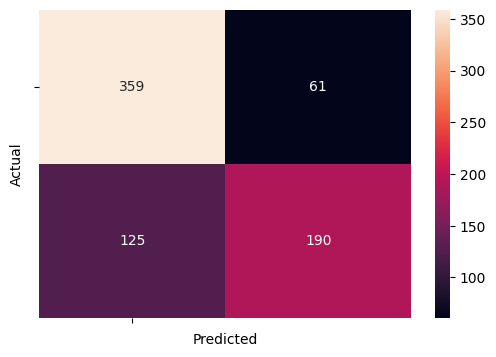

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       420
           1       0.76      0.60      0.67       315

    accuracy                           0.75       735
   macro avg       0.75      0.73      0.73       735
weighted avg       0.75      0.75      0.74       735

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       420
           1       0.76      0.60      0.67       315

    accuracy                           0.75       735
   macro avg       0.75      0.73      0.73       735
weighted avg       0.75      0.75      0.74       735



In [ ]:
conf_mat = confusion_matrix(y_test_tsne, y_pred_AB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_tsne, y_pred_AB))
print(classification_report(y_test_tsne, y_pred_AB))

# Extrem Gradient Boosting

In [ ]:
X_train_XGB = x_train.copy()
y_train_XGB = y_train_Goles_Local.copy()
X_test_XGB = x_test.copy()
y_test_XGB = y_test_Goles_Local.copy()

###Dataset Completo

#### Entrenamiento del modelo

In [ ]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)
# Train the model
xgb_model.fit(X_train_XGB, y_train_XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred_XGB = xgb_model.predict(X_test_XGB)

# Calculate accuracy of predictions
accuracy = accuracy_score(y_test_XGB, y_pred_XGB)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.90%


#### Matriz de confusión

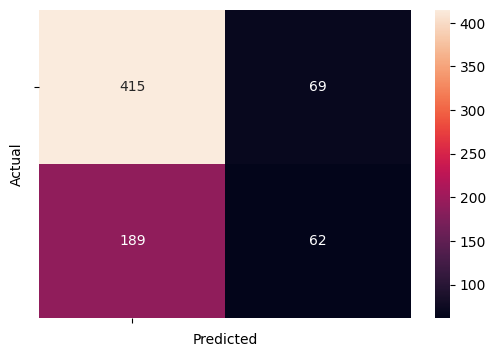

              precision    recall  f1-score   support

           0       0.69      0.86      0.76       484
           1       0.47      0.25      0.32       251

    accuracy                           0.65       735
   macro avg       0.58      0.55      0.54       735
weighted avg       0.61      0.65      0.61       735

              precision    recall  f1-score   support

           0       0.69      0.86      0.76       484
           1       0.47      0.25      0.32       251

    accuracy                           0.65       735
   macro avg       0.58      0.55      0.54       735
weighted avg       0.61      0.65      0.61       735



In [ ]:
conf_mat = confusion_matrix(y_test_XGB, y_pred_XGB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_XGB, y_pred_XGB))
print(classification_report(y_test_XGB, y_pred_XGB))

#### Curva ROC

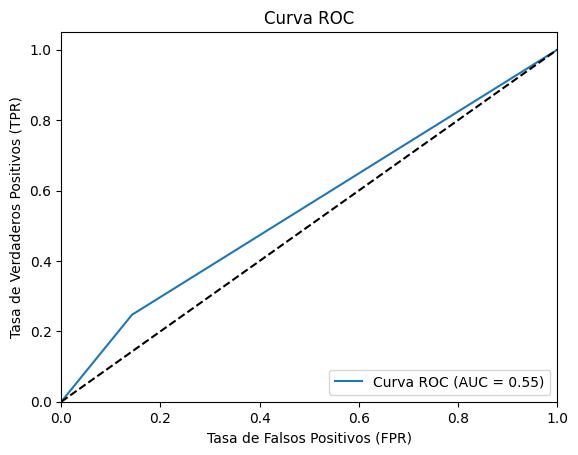

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_XGB, y_pred_XGB)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Mejores parametros

In [ ]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Perform grid search to find best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_XGB, y_train_XGB)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

y_pred_XGB = grid_search.predict(X_test_XGB)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#### Nueva Matriz

In [ ]:
conf_mat = confusion_matrix(y_test_XGB, y_pred_XGB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_XGB, y_pred_XGB))
print(classification_report(y_test_XGB, y_pred_XGB))

###Dataset T-SNE

In [ ]:
# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.1, n_estimators=100)
# Train the model
xgb_model.fit(X_train_tsne, y_train_tsne)
y_pred_XGB = xgb_model.predict(X_test_tsne)
# Calculate accuracy of predictions
accuracy = accuracy_score(y_test_tsne, y_pred_XGB)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.23%


####Matriz de confusión T-SNE

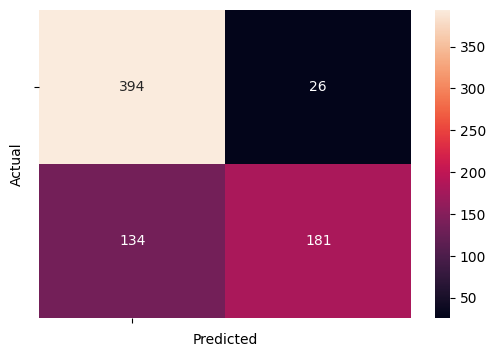

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       420
           1       0.87      0.57      0.69       315

    accuracy                           0.78       735
   macro avg       0.81      0.76      0.76       735
weighted avg       0.80      0.78      0.77       735

              precision    recall  f1-score   support

           0       0.75      0.94      0.83       420
           1       0.87      0.57      0.69       315

    accuracy                           0.78       735
   macro avg       0.81      0.76      0.76       735
weighted avg       0.80      0.78      0.77       735



In [ ]:
conf_mat = confusion_matrix(y_test_tsne, y_pred_XGB)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_tsne, y_pred_XGB))
print(classification_report(y_test_tsne, y_pred_XGB))

# Histogram Gradient Boosting

In [ ]:
X_train_HGradient = x_train.copy()
y_train_HGradient = y_train_Goles_Local.copy()
X_test_HGradient = x_test.copy()
y_test_HGradient = y_test_Goles_Local.copy()

###Dataset completo

#### Entrenamiento del modelo

In [ ]:
# Definir conjunto de datos LightGBM
train_data = lgb.Dataset(X_train_HGradient, label=y_train_HGradient)

In [ ]:
#Definir hiperparámetros
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "n_estimators": 100
}

# Entrenar modelo de Histogram Gradient Boosting
model = lgb.train(params, train_data)

# Predecir y evaluar el modelo
y_pred_HG = model.predict(X_test_HGradient)
y_pred_HG = [1 if p >= 0.5 else 0 for p in y_pred_HG]
accuracy = accuracy_score(y_test_HGradient, y_pred_HG)
print(f"Precisión: {accuracy}")

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1246, number of negative: 1694
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2369
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.423810 -> initscore=-0.307154
[LightGBM] [Info] Start training from score -0.307154
Precisión: 0.6421768707482993


#### Matriz de confusión

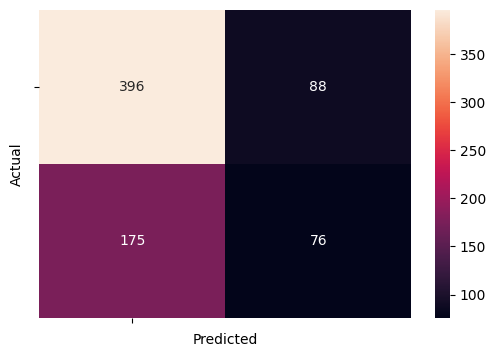

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       484
           1       0.46      0.30      0.37       251

    accuracy                           0.64       735
   macro avg       0.58      0.56      0.56       735
weighted avg       0.61      0.64      0.62       735

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       484
           1       0.46      0.30      0.37       251

    accuracy                           0.64       735
   macro avg       0.58      0.56      0.56       735
weighted avg       0.61      0.64      0.62       735



In [ ]:
conf_mat = confusion_matrix(y_test_HGradient, y_pred_HG)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_HGradient, y_pred_HG))
print(classification_report(y_test_HGradient, y_pred_HG))

#### Curva ROC

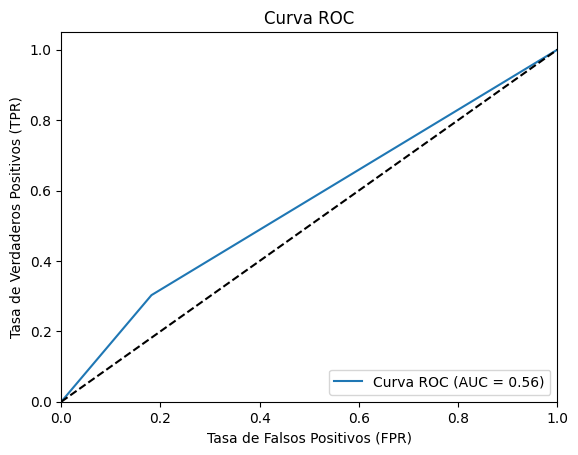

In [ ]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_HGradient, y_pred_HG)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### Validación Cruzada

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "n_estimators": 100
}

# Definir validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Realizar validación cruzada
cv_results = lgb.cv(
    params,
    lgb.Dataset(X_train_GFradient, label = y_train_GFradient),
    num_boost_round=1000,
    folds=kf.split(X_train_GFradient),
    early_stopping_rounds=10,
    verbose_eval=False,
    metrics=["binary_logloss", "auc","f1"]
)

# Mostrar resultados de validación cruzada
print("Resultados de validación cruzada:")
print(f"  LogLoss: {cv_results['binary_logloss-mean'][-1]:.4f} +/- {cv_results['binary_logloss-stdv'][-1]:.4f}")
print(f"  AUC: {cv_results['auc-mean'][-1]:.4f} +/- {cv_results['auc-stdv'][-1]:.4f}")

###Dataset T-SNE

In [ ]:
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne

In [ ]:
# Definir conjunto de datos LightGBM
train_data = lgb.Dataset(X_train_tsne, label=y_train_tsne)
#Definir hiperparámetros
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "n_estimators": 100
}

# Entrenar modelo de Histogram Gradient Boosting
model = lgb.train(params, train_data)

# Predecir y evaluar el modelo
y_pred_HG = model.predict(X_test_tsne)
y_pred_HG = [1 if p >= 0.5 else 0 for p in y_pred_HG]
accuracy = accuracy_score(y_test_tsne, y_pred_HG)
print(f"Precisión: {accuracy}")

[LightGBM] [Info] Number of positive: 1182, number of negative: 1758
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2940, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402041 -> initscore=-0.396969
[LightGBM] [Info] Start training from score -0.396969
Precisión: 0.8136054421768707


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


####Matriz de confusión T-SNE

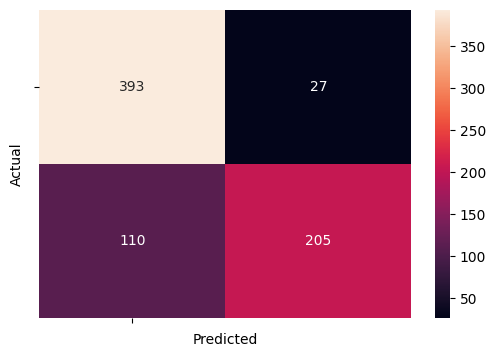

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       420
           1       0.88      0.65      0.75       315

    accuracy                           0.81       735
   macro avg       0.83      0.79      0.80       735
weighted avg       0.83      0.81      0.81       735

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       420
           1       0.88      0.65      0.75       315

    accuracy                           0.81       735
   macro avg       0.83      0.79      0.80       735
weighted avg       0.83      0.81      0.81       735



In [ ]:
conf_mat = confusion_matrix(y_test_tsne, y_pred_HG)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=np.unique(Y.sort())
            , yticklabels=np.unique(Y.sort())
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test_tsne, y_pred_HG))
print(classification_report(y_test_tsne, y_pred_HG))

#Preguntas

##Deberia traer la tempora o año del partido

##Deberia hacer encoder de las columnas de local y visitante para los partidos historicos

## deberia traer los ultimos enfrentamientos entre los equipos

##Los goles de los partidos historia tambien deberian ir etiquetados

voy antes del Fgradient boosting, hay unas fechas nulas cuadrar eso y seguir